In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from scipy.stats import linregress

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
trump = pd.read_csv('trump_legacy/Trumps Legcy.csv')
stock = pd.read_csv('sp500_daily/sp500_stocks.csv')

In [5]:
trump['date'] = pd.to_datetime(trump['date'])
trump = trump.sort_values('date')

In [6]:
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock.sort_values('Date')

In [7]:
def is_only_link(text):
    text = text.strip()
    return text.startswith('http://') or text.startswith('https://') and ' ' not in text

# Remove rows where text is only a link
link_filtered = trump[~trump['text'].apply(is_only_link)]

In [8]:
# Remove rows where text is a retweet
retweet_filtered = link_filtered[~link_filtered['text'].str.startswith('RT')]

In [9]:
# Remove all links entirely
def remove_links(text):
    return ' '.join([word for word in text.split() if not is_only_link(word)])

trump['text'] = retweet_filtered['text'].apply(remove_links)
trump.dropna(subset=['text'], inplace=True)

In [10]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

vectorized_get_polarity = np.vectorize(get_polarity)

trump['polarity'] = vectorized_get_polarity(trump['text'])

In [11]:
trump['polarityCumulative'] = trump['polarity'].cumsum()

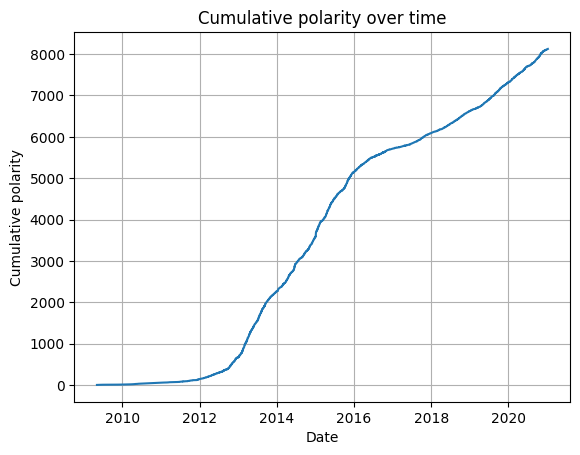

In [12]:
# Validating result is of similar trend to the EDA result
fig, ax = plt.subplots()
ax.plot(trump['date'], trump['polarityCumulative'])
ax.set(xlabel='Date', ylabel='Cumulative polarity',
       title='Cumulative polarity over time')
ax.grid()
plt.show()

In [29]:
def flatten_trend(x, y):
    x = mdates.date2num(x)
    slope, intercept, _, _, _ = linregress(x, y)
    trend_line = (slope * x) + intercept
    deviation = y - trend_line
    flat_average = np.mean(y)
    transformed_value = flat_average + deviation

    slope, intercept, _, _, _ = linregress(x, transformed_value)
    const_trend_line = (slope * x) + intercept
    # Subtract the constant trend line to get the final trend
    transformed_value -= const_trend_line
    slope, intercept, _, _, _ = linregress(x, transformed_value)
    const_trend_line = (slope * x) + intercept
    
    return trend_line, transformed_value, const_trend_line

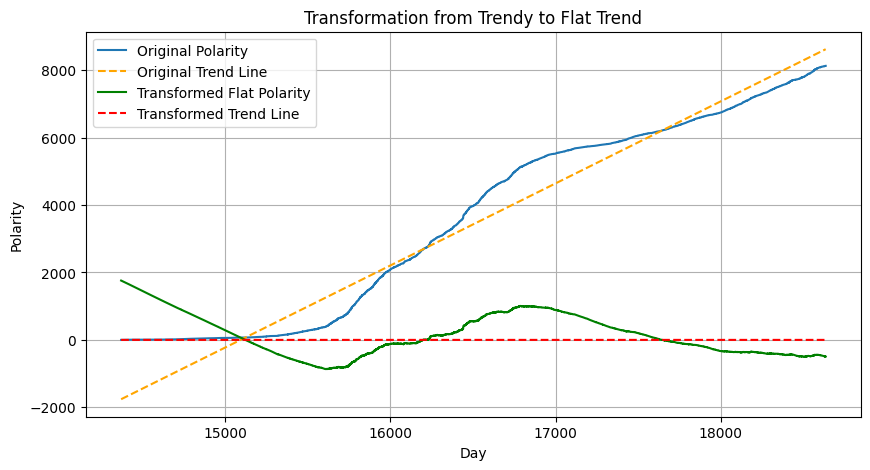

In [14]:
x = mdates.date2num(trump['date'])
trend_line, transformed_polarity, const_trend_line = flatten_trend(trump['date'], trump['polarityCumulative'])

plt.figure(figsize=(10, 5))
plt.plot(x, trump['polarityCumulative'], label='Original Polarity')
plt.plot(x, trend_line, label='Original Trend Line', linestyle='--', color='orange')
plt.plot(x, transformed_polarity, label='Transformed Flat Polarity', color='green')
plt.plot(x, const_trend_line, label='Transformed Trend Line', linestyle='--', color='red')
plt.title('Transformation from Trendy to Flat Trend')

plt.xlabel('Day')
plt.ylabel('Polarity')
plt.legend()
plt.grid(True)
plt.show()

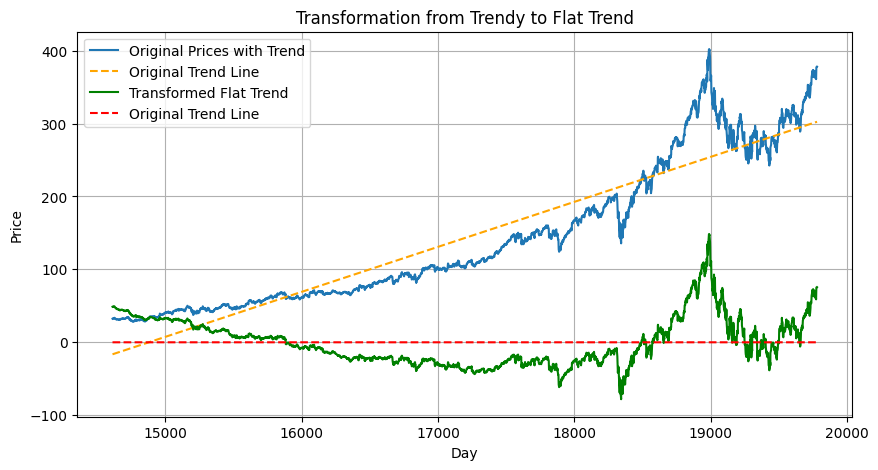

In [15]:
company_stock = stock[stock['Symbol'] == "ACN"]
x = mdates.date2num(company_stock['Date'])

trend_line, transformed_polarity, const_trend_line = flatten_trend(company_stock['Date'], company_stock['Adj Close'])

plt.figure(figsize=(10, 5))
plt.plot(x, company_stock['Adj Close'], label='Original Prices with Trend')
plt.plot(x, trend_line, label='Original Trend Line', linestyle='--', color='orange')
plt.plot(x, transformed_polarity, label='Transformed Flat Trend', color='green')
plt.plot(x, const_trend_line, label='Original Trend Line', linestyle='--', color='red')
plt.title('Transformation from Trendy to Flat Trend')

plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

0.0032401458503037482


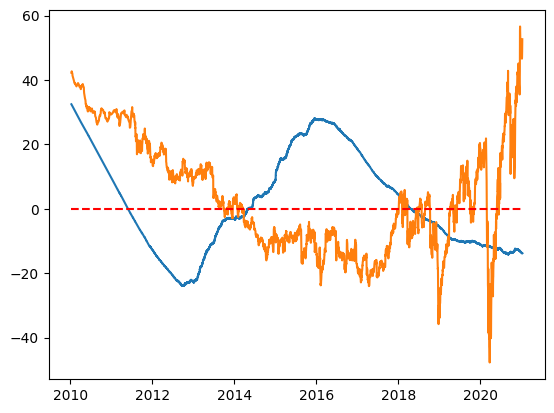

In [16]:
method = "pearson"
stock_type = "Adj Close"
correlations = {}
companies = stock['Symbol'].unique()
top_stock = {}
company = "ACN"

trump_2 = trump.copy()

company_stock = stock[stock['Symbol'] == company]
company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()

scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])

company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]

trump_dates = company_trump['date']
stock_values = company_stock[['Date', stock_type]]
missing_dates = trump_dates[~trump_dates.isin(stock_values['Date'])]
stock_values = pd.concat([stock_values, pd.DataFrame({'Date': missing_dates, stock_type: np.nan})], ignore_index=True)
stock_values = stock_values.sort_values('Date')
stock_values = stock_values.reset_index(drop=True)
stock_values[stock_type] = stock_values[stock_type].interpolate()
stock_values = stock_values[stock_values['Date'].isin(trump_dates)]

_, transformed_polarity, _ = flatten_trend(company_trump['date'], company_trump['polarityScaled'])
company_trump["transformedPolarityScaled"] = transformed_polarity
_, transformed_adj_close, _ = flatten_trend(stock_values['Date'], stock_values[stock_type])
company_stock["transformedAdjClose"] = transformed_adj_close

plt.plot(company_trump["date"], transformed_polarity)
plt.plot(stock_values["Date"], transformed_adj_close)
plt.hlines(y=0, xmin=stock_values["Date"].min(), xmax=stock_values["Date"].max(), color='r', linestyle='--')

correlation = abs(transformed_polarity.corr(transformed_adj_close, method=method))
print(correlation)
plt.show()

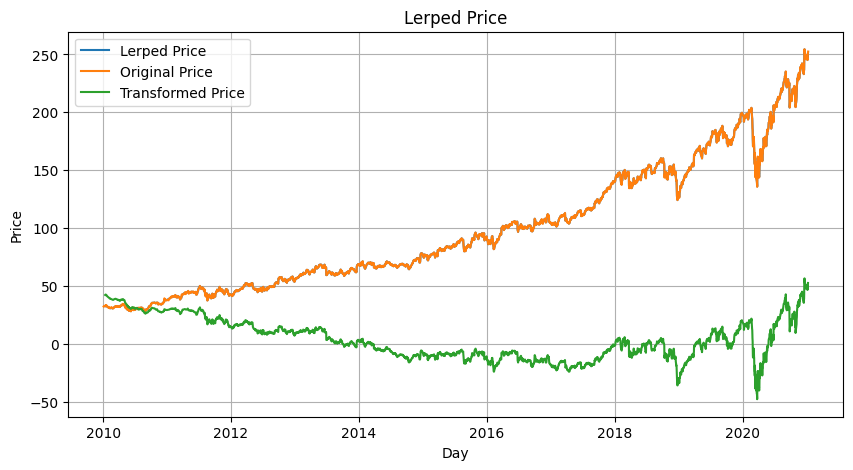

In [17]:
# Plot lerped price
plt.figure(figsize=(10, 5))
plt.plot(company_trump['date'], stock_values["Adj Close"], label='Lerped Price')
plt.plot(company_stock['Date'], company_stock["Adj Close"], label='Original Price')
plt.plot(stock_values['Date'], transformed_adj_close, label="Transformed Price")
plt.title('Lerped Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
method = "spearman"
stock_type = "Adj Close"
correlations = {}
companies = stock['Symbol'].unique()
top_stock = {}

for company in companies:
    trump_2 = trump.copy()

    company_stock = stock[stock['Symbol'] == company]
    company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

    stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
    stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()

    scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
    trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
    trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])

    company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]

    trump_dates = company_trump['date']
    stock_values = company_stock[['Date', stock_type]]
    missing_dates = trump_dates[~trump_dates.isin(stock_values['Date'])]
    stock_values = pd.concat([stock_values, pd.DataFrame({'Date': missing_dates, stock_type: np.nan})], ignore_index=True)
    stock_values = stock_values.sort_values('Date')
    stock_values = stock_values.reset_index(drop=True)
    stock_values[stock_type] = stock_values[stock_type].interpolate()
    stock_values = stock_values[stock_values['Date'].isin(trump_dates)]

    transformed_polarity = company_trump['polarityScaled']
    transformed_adj_close = stock_values[stock_type]

    # _, transformed_polarity, _ = flatten_trend(company_trump['date'], company_trump['polarityScaled'])
    # company_trump["transformedPolarityScaled"] = transformed_polarity
    # _, transformed_adj_close, _ = flatten_trend(stock_values['Date'], stock_values[stock_type])
    # company_stock["transformedAdjClose"] = transformed_adj_close

    correlation = abs(transformed_polarity.corr(transformed_adj_close, method=method))
    correlations[company] = correlation
    if top_stock == {} or correlation > list(top_stock.values())[0]:
        top_stock = {company: correlation}

In [19]:
correlations = pd.Series(correlations)
correlations = correlations.sort_values(ascending=False)
correlations.head(10)

PAYC    0.898496
ALLE    0.877096
PYPL    0.860827
CZR     0.814597
FOXA    0.796395
VTRS    0.791629
KEYS    0.786634
CTLT    0.779449
FOX     0.779124
HLT     0.747058
dtype: float64

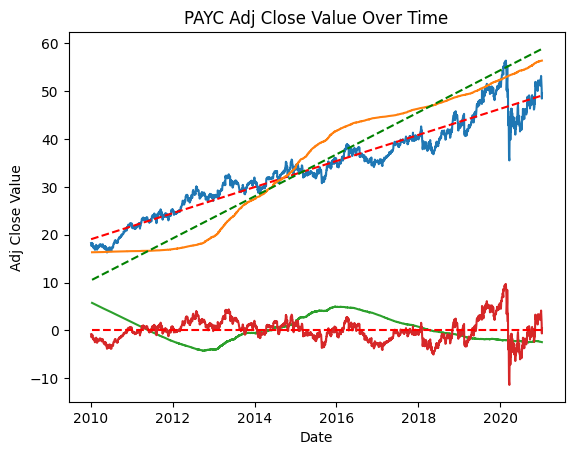

In [30]:
symbol = list(top_stock.keys())[0]

company_stock = stock[stock['Symbol'] == company]
company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()

scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])

company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]

plt.plot(company_stock['Date'], company_stock[stock_type])
z = np.polyfit(mdates.date2num(company_stock['Date']), company_stock[stock_type], 1)
p = np.poly1d(z)
plt.plot(company_stock['Date'], p(mdates.date2num(company_stock['Date'])), "r--", label='Trend Line (Stock)')

plt.plot(company_trump['date'], company_trump['polarityScaled'])
z_polarity = np.polyfit(mdates.date2num(company_trump['date']), company_trump['polarityScaled'], 1)
p_polarity = np.poly1d(z_polarity)
plt.plot(company_trump['date'], p_polarity(mdates.date2num(company_trump['date'])), "g--", label='Trend Line (Polarity)')

# Plot the flattened trend
_, transformed_polarity, _ = flatten_trend(company_trump['date'], company_trump['polarityScaled'])
company_trump["transformedPolarityScaled"] = transformed_polarity
_, transformed_adj_close, _ = flatten_trend(company_stock['Date'], company_stock[stock_type])
company_stock["transformedAdjClose"] = transformed_adj_close

# print(transformed_adj_close)

plt.plot(company_trump['date'], transformed_polarity)
plt.plot(company_stock['Date'], transformed_adj_close)
plt.hlines(y=0, xmin=stock_values["Date"].min(), xmax=stock_values["Date"].max(), color='r', linestyle='--')

plt.xlabel('Date')
plt.ylabel(stock_type + ' Value')
plt.title(symbol + ' ' + stock_type + ' Value Over Time')
plt.show()